In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from twitter.twitter_collection import TwitterCollection
from twitter.tweet_sentiment_analyzer import TweetSentimentAnalyzer
from data_pipelines.data_manipulation import DataManipulation
from logger.logger import Logger

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

In [2]:
SYMBOL = 'BTC-USD'
SYMBOL_NAME = 'Bitcoin'
SYMBOL_CUT = 'btc'
scale = 1
range_list = [i for i in range(5,21)]
range_list = [i*scale for i in range_list]
interval = '1d'
start_date = '2020-06-30'
end_date = '2022-07-01'
source = 'yahoo'
LOG_PATH = '../logger' + os.sep + "logs"
LOG_FILE_NAME_PREFIX = f"log_{SYMBOL_CUT}_{start_date}_{end_date}"

logger = Logger(LOG_PATH, LOG_FILE_NAME_PREFIX)
tsa = TweetSentimentAnalyzer()
data = DataManipulation(SYMBOL, source, range_list, start_date=start_date, 
                        end_date=end_date, interval=interval, scale=scale, 
                        prefix_path='..', saved_to_csv=True,
                        logger=logger)
df_price = data.df.copy()

1 ) 22-12-2022 20_21_20 MainThread INFO\ Initialized logging at path ../logger/logs/log_btc_2020-06-30_2022-07-01_22-12-2022_20_21_20.log
2 ) 22-12-2022 20_21_20 MainThread DEBUG\ Get data from local file ../data/outputs/data_ind/BTC-USD/BTC-USD_df_2020-06-30_2022-07-01_1d.csv


In [3]:
df_price_ext = data.extract_features()
close_col = df_price.loc['2021-01-01':'2022-06-27',['close','volume']].copy()

3 ) 22-12-2022 20_21_35 MainThread DEBUG\ Get features matrix from ../data/outputs/feature_data/BTC-USD BTC-USD_df_2020-06-30_2022-07-01_1d.csv


In [4]:
sent_tweets = pd.read_csv('btc_archieve/btc_daily_sent_score.csv')
sent_tweets.Date = pd.to_datetime(sent_tweets.Date)
sent_tweets.set_index('Date', inplace=True, drop=True)

In [ ]:
sent_tweets.index = sent_tweets.index.tz_convert(None)

In [5]:
df_final = tsa.concat_ohlc_compound_score(df_price_ext, sent_tweets)
df_final = df_final.loc['2021-01-01':,:].copy()
df_final.dropna(inplace=True)

Concantenation for sentiment score tweets and indicator MAtrix data


In [6]:
df_final.shape

(543, 211)

Text(0.5, 1.0, 'Bitcoin Proce')

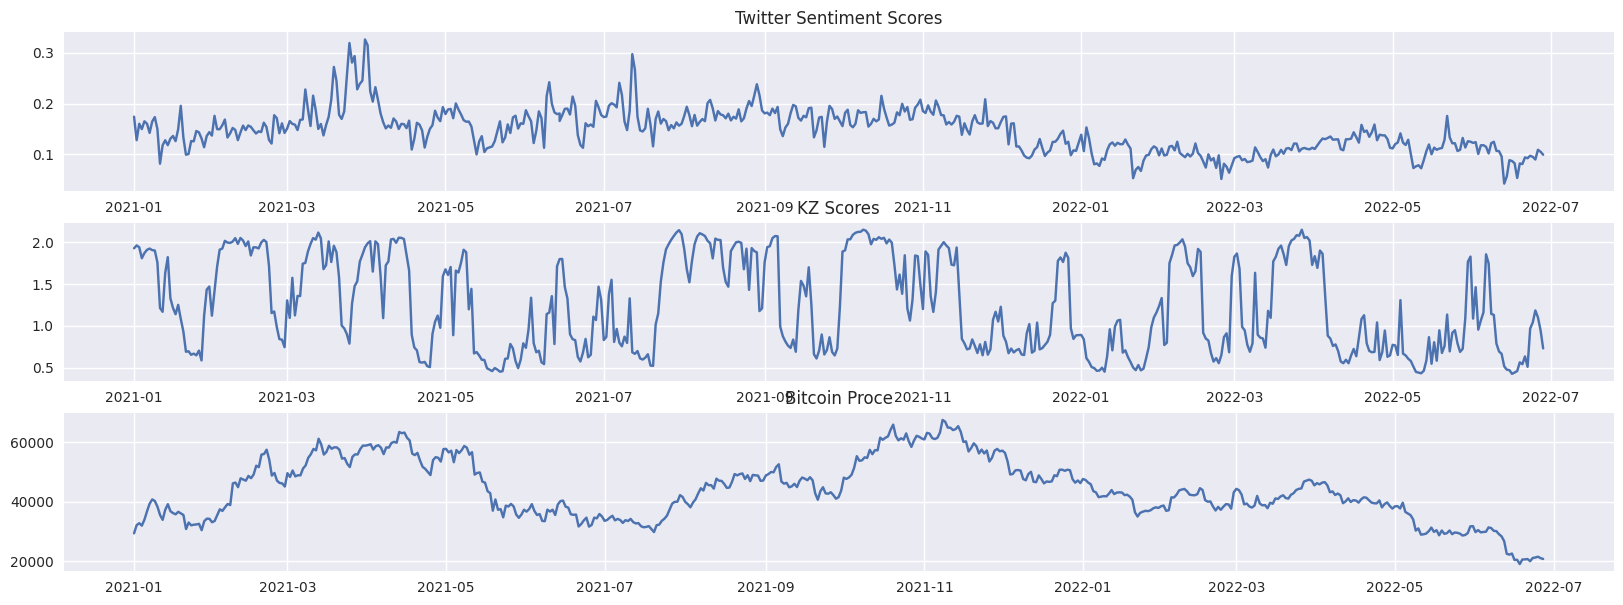

In [7]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(20,7))
ax1.plot(df_final.compound_total)
ax1.set_title('Twitter Sentiment Scores')
ax2.plot(df_final.index, df_final.kz_score)
ax2.set_title('KZ Scores')
ax3.plot(close_col.index, close_col.close)
ax3.set_title('Bitcoin Proce')

In [8]:
df = df_final.copy()
df.reset_index(drop=True, inplace=True)
df.head()

,st_stoch,st_ich,st_cut_ema5_sma10,st_macd,st_ich_close,st_dmi,st_cut_sma10_close,st_hisse,st_mfi,st_fishert,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,feature_label,kz_score,compound_total
0,0,1,1,1,1,1,0,0,3,3,...,1,1,1,0,1,1,1,1.0000,1.9276,0.1744
1,0,1,1,1,1,1,0,0,3,3,...,1,1,1,1,0,1,1,1.0000,1.9622,0.1280
2,0,1,1,1,1,1,0,0,3,3,...,1,1,1,1,1,0,1,0.0000,1.9399,0.1604
3,0,1,1,1,1,1,0,0,3,3,...,1,1,1,1,1,1,0,1.0000,1.8085,0.1499
4,0,1,1,1,1,1,0,0,3,3,...,1,1,1,1,1,1,1,1.0000,1.8705,0.1652


In [9]:
y = df_final.log_return
X = df_final.drop(columns=['log_return'], axis=1)

In [11]:
(y > 0).astype(int)

2021-01-01    1
2021-01-02    1
2021-01-03    1
2021-01-04    0
2021-01-05    1
             ..
2022-06-24    1
2022-06-25    1
2022-06-26    0
2022-06-27    0
2022-06-28    0
Name: log_return, Length: 543, dtype: int64

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)
Training score:  0.9996744887680219
Mean cross-validation score: 0.45
K-fold CV average score: 0.45
MSE: 0.00
RMSE: 0.03


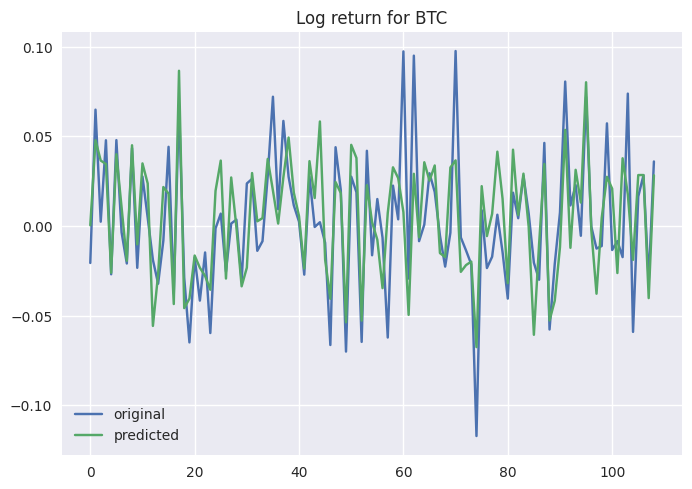

In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.20)
xgbr = XGBRegressor(tree_method='gpu_hist', n_estimators=150, verbosity=0) 
print(xgbr)

xgbr.fit(xtrain, ytrain)

score = xgbr.score(xtrain, ytrain)  
print("Training score: ", score)

scores = cross_val_score(xgbr, xtrain, ytrain, cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=False)
kf_cv_scores = cross_val_score(xgbr, xtrain, ytrain, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

ypred_reg = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred_reg)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

x_ax = range(len(ytest))
plt.plot(x_ax, ytest, label="original")
plt.plot(x_ax, ypred_reg, label="predicted")
plt.title("Log return for BTC")
plt.legend()
plt.show()

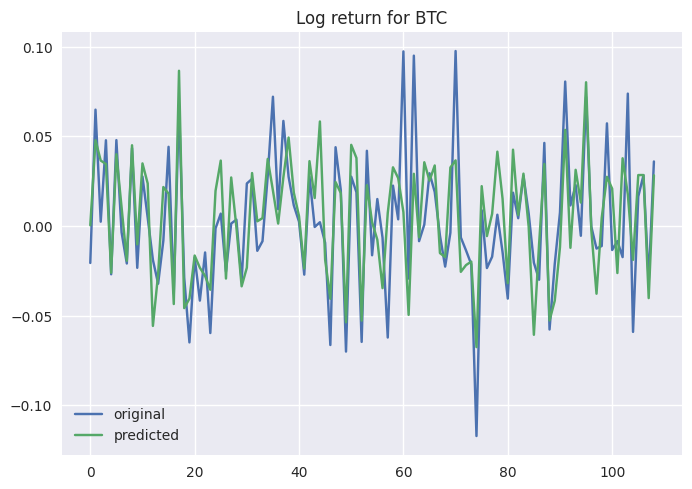

In [13]:
x_ax = range(len(ytest))
plt.plot(x_ax, ytest, label="original")
plt.plot(x_ax, ypred_reg, label="predicted")
plt.title("Log return for BTC")
plt.legend()
plt.show()

In [ ]:
import numpy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import os


class XgboostForecasting():

    def __init__(self, n_estimators: int=100, tree_method: str='gpu_hist', eta: float=0.1, 
                    max_depth: int=1, objective: str='binary', eval_metric: str='logloss', 
                    cv: int=0, is_kfold: bool=False, logger: Logger=None):
        self.n_estimators = n_estimators
        self.tree_method = tree_method
        self.eta = eta
        self.max_depth = max_depth
        self.objective = objective
        self.eval_metric = eval_metric
        self.cv = cv
        self.is_kfold = is_kfold
        self.logger = logger
        if self.objective == 'binary':
            self.model = XGBClassifier(n_estimators=self.n_estimators, tree_method=self.tree_method, 
                    eta=self.eta, max_depth=self.max_depth)
        elif self.objective == 'regression':
            self.model = XGBRegressor(n_estimators=self.n_estimators, tree_method=self.tree_method, 
                    eta=self.eta, max_depth=self.max_depth)
        else: 
            print(f'You must use objective BINARY or REGRESSION')
        

    def create_train_test_data(self, x, y, test_size):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(x, y, test_size=test_size, shuffle=False)  
        self.evalset = [(self.X_train, self.y_train), (self.X_test, self.y_test)]  

    def fit(self):
        self.model.fit(self.X_train, self.y_train, eval_metric=self.eval_metric, eval_set=self.evalset)
        if self.cv > 0 and self.is_kfold:
            kfold = KFold(n_splits=self.cv, shuffle=False)
            self.kf_cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=kfold)
        if self.cv > 0:
            self.cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=self.cv)
            

    def get_score(self):
        yhat = self.model.predict(self.X_test)
        if self.objective == 'binary':
            scr = accuracy_score(self.y_test, yhat)
            print(f'Accuracy Score for binary classification is: {scr}')
        elif self.objective == 'regression' and self.is_kfold:  
            scr = self.kf_cv_scores.mean()
            print(f'Score for Mean {self.cv} Kfold is: {self.kf_cv_scores.mean()}')
        elif self.objective == 'regression' and self.cv > 0:  
            scr = self.cv_scores.mean()
            print(f'Score for Mean {self.cv} Cross-Validation is: {self.cv_scores.mean()}')
        elif self.objective == 'regression':
            scr = self.model.score(self.X_train, self.y_train)  
            print(f'Score for Train set regression is: {scr}')
        return scr

    def plot_learning_curves(self):
        self.results = self.model.evals_result()
        fig, ax = plt.subplots()
        ax.plot(self.results['validation_0'][self.eval_metric], label='train')
        ax.plot(self.results['validation_1'][self.eval_metric], label='test')
        ax.legend()

    def save_model(self, file_name: str):
        self.model.save_model(file_name)

    def load_model(self, file_name: str):
        self.model.load_model(file_name)

    def bestparams_gridcv(self, n_estimators_list: list, eta_list: list, 
                            max_depth_list: list, verbose: int=0, is_plot: bool=False) -> tuple:

        param_grid = dict(max_depth=max_depth_list, n_estimators=n_estimators_list, eta=eta_list)
        tscv = TimeSeriesSplit(n_splits=5)
        grid_search = GridSearchCV(self.model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=tscv,
                verbose=verbose)
        grid_result = grid_search.fit(self.X_train, self.y_train)

        if verbose > 0:
            print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
            means = grid_result.cv_results_['mean_test_score']
            stds = grid_result.cv_results_['std_test_score']
            params = grid_result.cv_results_['params']
            for mean, stdev, param in zip(means, stds, params):
                print("%f (%f) with: %r" % (mean, stdev, param))

            
        if is_plot:
            means = grid_result.cv_results_['mean_test_score']
            scores = numpy.array(means).reshape(len(max_depth_list), len(n_estimators_list))
            print(scores)
            for i, value in enumerate(max_depth_list):
                plt.plot(n_estimators_list, scores[i], label='depth: ' + str(value))
                plt.legend()
                plt.savefig('estimator_best_param.png')
        
        return grid_result.best_params_
        

    def get_model_names(self):
        files = os.listdir('.')
        list_files = []
        for f in files:
            if f.endswith('.json'):
                list_files.append(f)
        print(f'Existing model names are: {list_files}')


y = (df_final.log_return > 0).astype(int)                            #df_final.feature_label
X = df_final.drop(columns=['log_return'], axis=1)                    #df_final.drop(columns=['feature_label'], axis=1)
xgb = XgboostForecasting(objective='binary', n_estimators=100, eta=0.3, max_depth=1, 
                    tree_method='gpu_hist', cv=10, eval_metric='logloss')
xgb.create_train_test_data(X, y, test_size=0.2)
xgb.fit()
xgb.save_model('model_file_name.json')
score = xgb.get_score()
#xgb.plot_learning_curves()
xgb.get_model_names()
best_params = xgb.bestparams_gridcv([100, 200], [0.1], [1,3], verbose=3, is_plot=True)
#yhat = (xgb.model.predict(xgb.X_test) > 0).astype(int)
#y_ = (xgb.y_test > 0).astype(int)
#accuracy = accuracy_score(yhat, y_)
#print('Accuracy: %.3f' % accuracy)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold

model = XGBClassifier(tree_method='gpu_hist')
n_estimators = [100, 200] # , 200, 300, 500, 1000, 50, 100, 
max_depth = [1, 2]  #, 6, 8, 12, 16
eta = [0.3, 0.1]

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, eta=eta)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=tscv,
                verbose=3)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print(type(grid_result.best_params_['eta']))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# plot results
import numpy
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))

{'st_stoch': 0.1772543, 'st_ich': 0.0, 'st_cut_ema5_sma10': 0.0, 'st_macd': 0.0, 'st_ich_close': 0.0, 'st_dmi': 0.0, 'st_cut_sma10_close': 0.0, 'st_hisse': 0.0, 'st_mfi': 0.0, 'st_fishert': 0.0, 'st_ema_5': 0.0, 'st_ema_6': 0.0, 'st_cut_ema_5_6': 0.0, 'st_ema_7': 0.0, 'st_ema_8': 0.0, 'st_cut_ema_7_8': 0.0, 'st_ema_9': 0.0, 'st_ema_10': 0.0, 'st_cut_ema_9_10': 0.0, 'st_ema_11': 0.0, 'st_ema_12': 0.0, 'st_cut_ema_11_12': 0.0, 'st_ema_13': 0.0, 'st_ema_14': 0.0, 'st_cut_ema_13_14': 0.0, 'st_ema_15': 0.0, 'st_ema_16': 0.0, 'st_cut_ema_15_16': 0.0, 'st_ema_17': 0.0, 'st_ema_18': 0.0, 'st_cut_ema_17_18': 0.0, 'st_ema_19': 0.0, 'st_ema_20': 0.0, 'st_cut_ema_19_20': 0.0, 'st_mfi_5': 0.012832385, 'st_mfi_6': 0.007185093, 'st_mfi_7': 0.010201825, 'st_mfi_8': 0.010933425, 'st_mfi_9': 0.0, 'st_mfi_10': 0.0, 'st_mfi_11': 0.007919857, 'st_mfi_12': 0.011248734, 'st_mfi_13': 0.0, 'st_mfi_14': 0.00647297, 'st_mfi_15': 0.0, 'st_mfi_16': 0.0077849277, 'st_mfi_17': 0.010863545, 'st_mfi_18': 0.0, 'st_mfi_

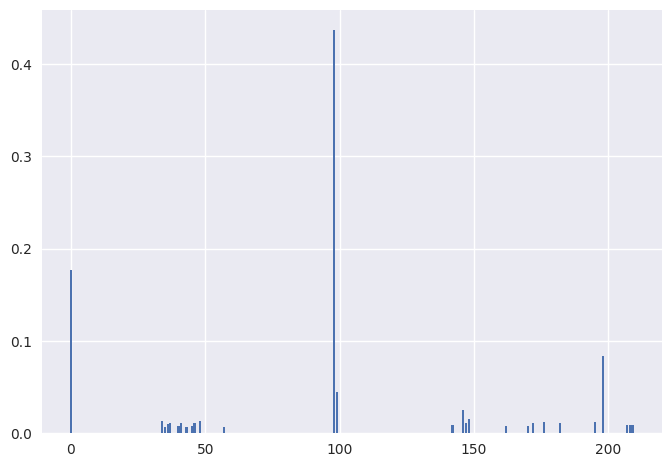

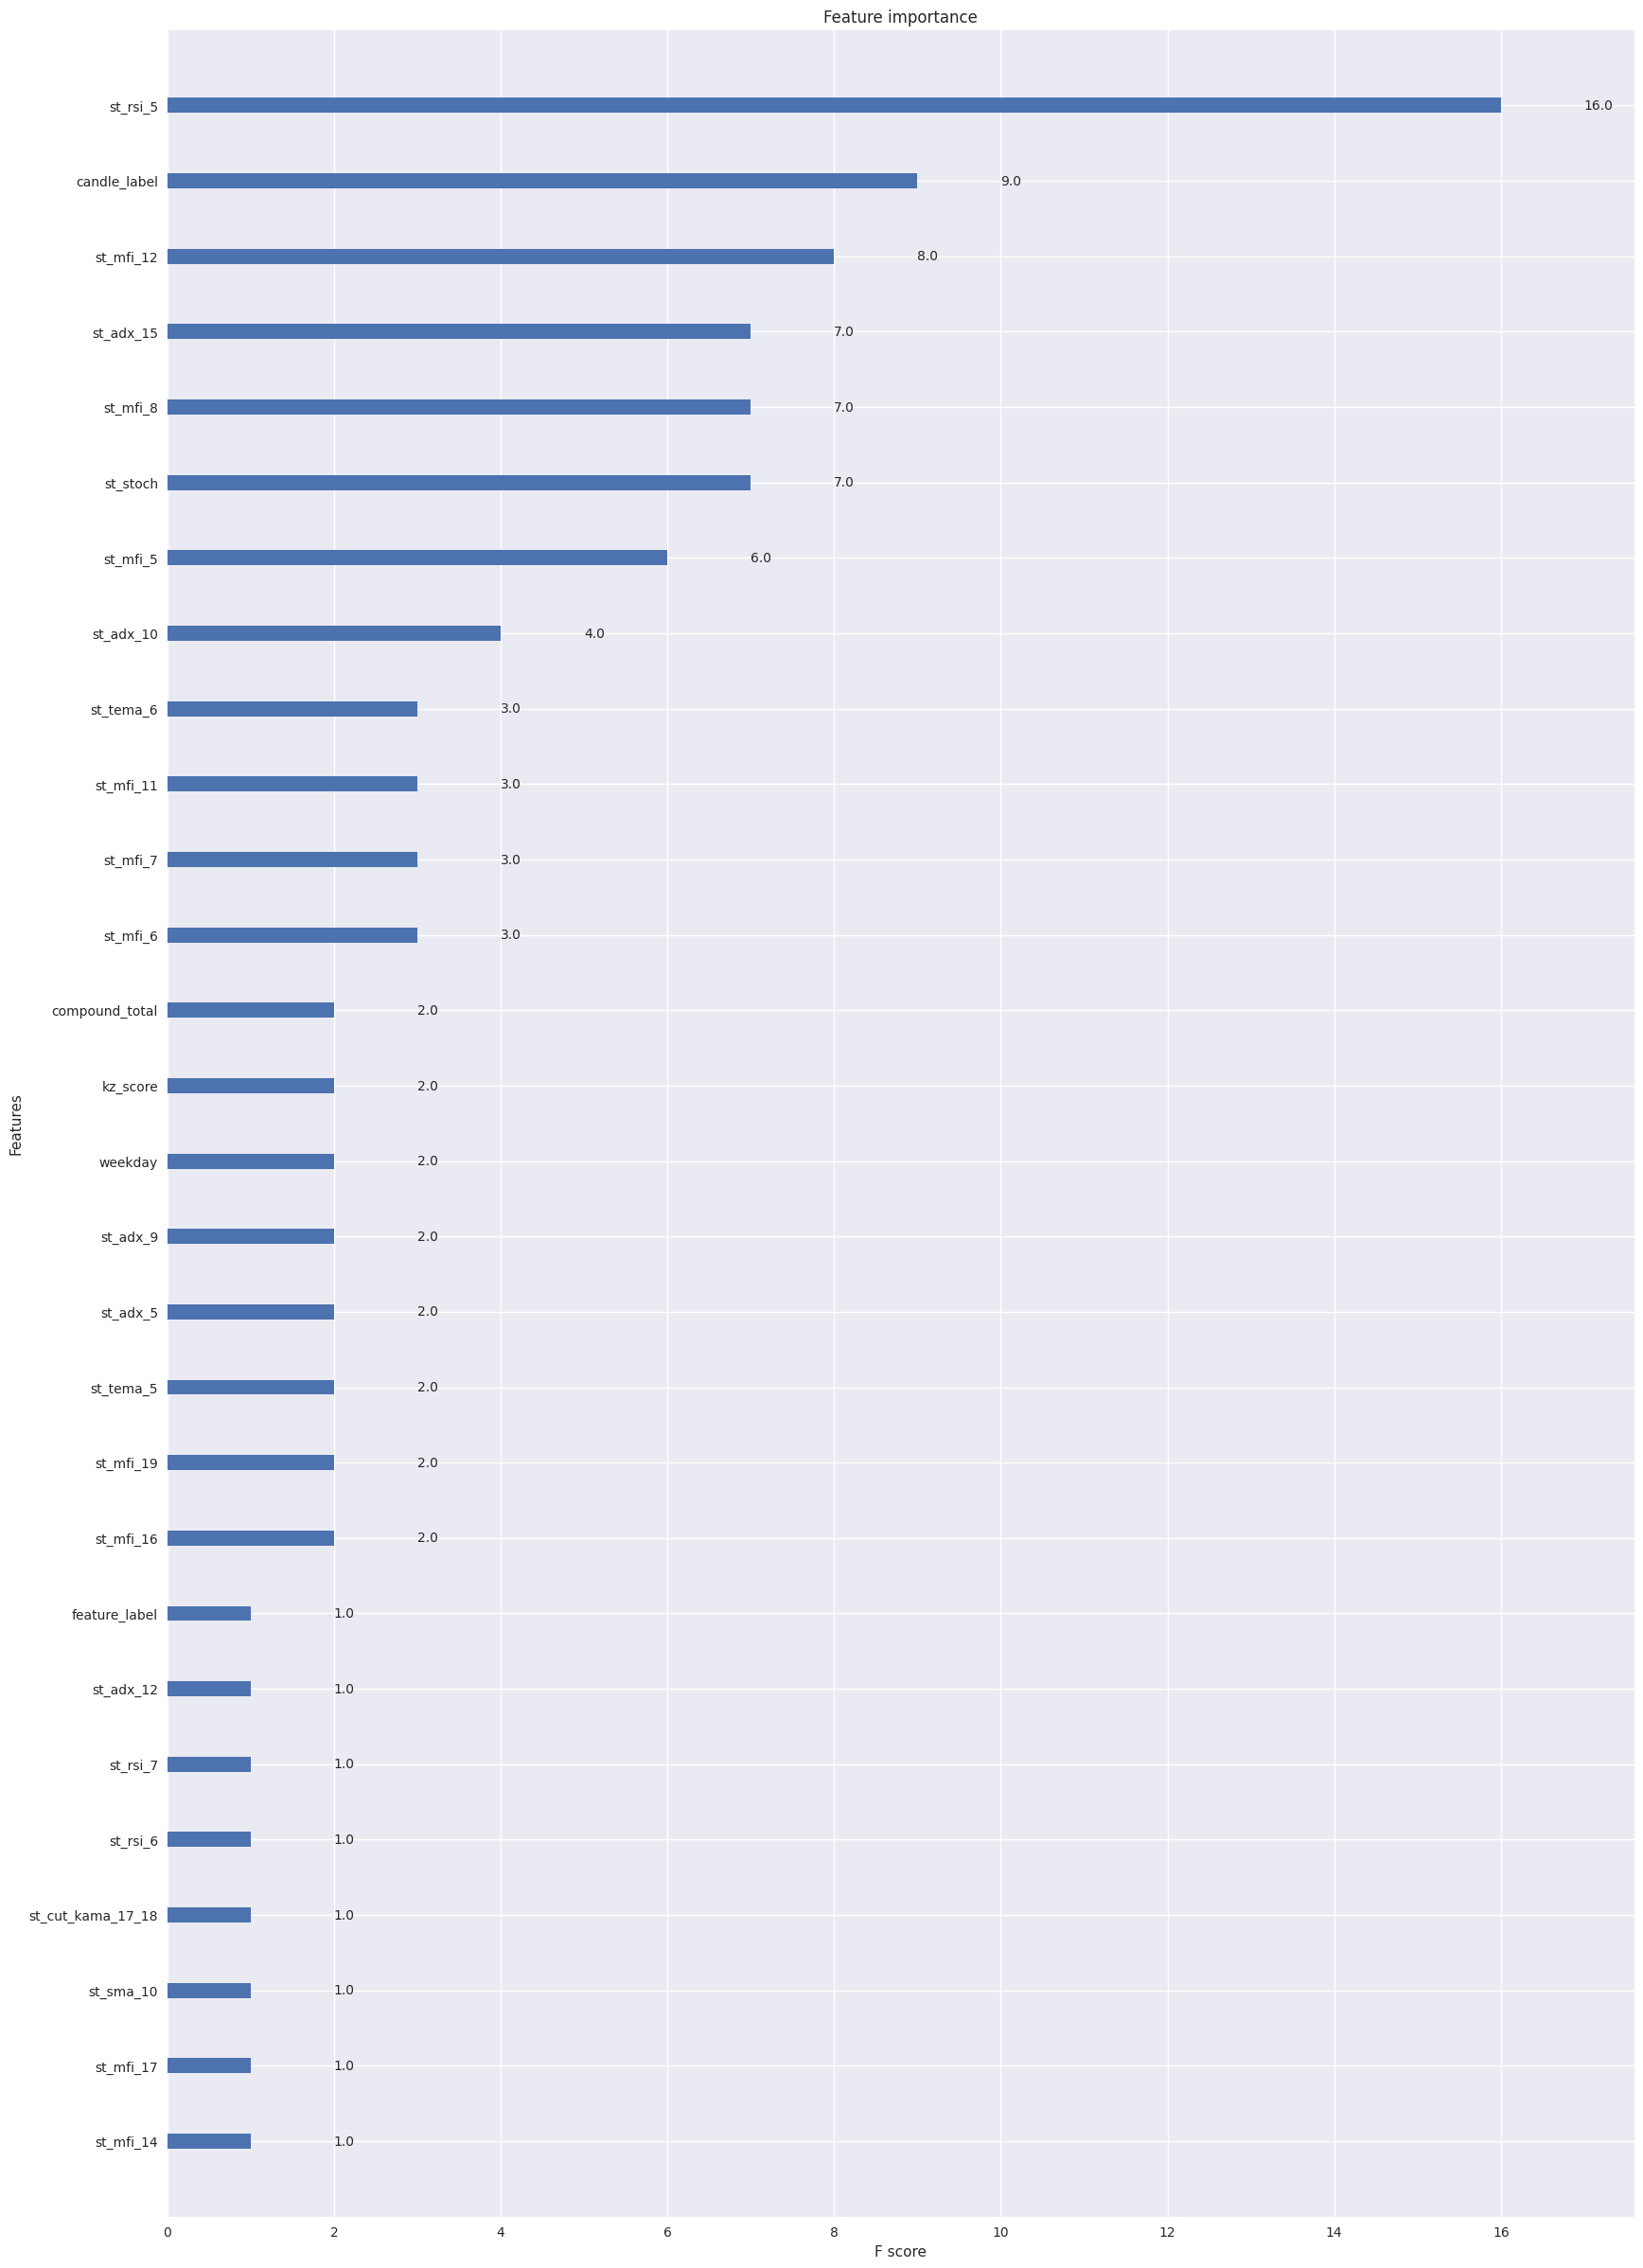

In [34]:
# After model.fit(x,y)
#model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)
col_list = xgb.X_train.columns.to_list()
dict_importance = {col_list[i]: xgb.model.feature_importances_[i] for i in range(len(col_list))}
print(dict_importance)

print(xgb.model.feature_importances_)
# plot
plt.bar(range(len(xgb.model.feature_importances_)), xgb.model.feature_importances_)
#pyplot.show()

from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(20,30))
plot_importance(xgb.model, ax=ax)
plt.show()